# Time series over the entire city

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
from sklearn.metrics import mean_absolute_error

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [3]:
data = pd.read_csv(
    '../data/Traffic_Collision_Data_from_2010_to_Present.csv'
)

In [4]:
data.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,190211527,05/18/2019,05/18/2019,110,2,Rampart,279,997,TRAFFIC COLLISION,3101 3401 3701 3004 3030,33.0,F,H,101.0,STREET,UNION,JAMES M WOOD,"(34.0508, -118.2731)"
1,110518459,10/11/2011,10/11/2011,1735,5,Harbor,505,997,TRAFFIC COLLISION,0506,27.0,F,O,101.0,STREET,VERMONT,KNOX,"(33.8542, -118.2905)"
2,180618348,08/09/2018,08/09/2018,1830,6,Hollywood,665,997,TRAFFIC COLLISION,3004 3028 3030 3035 3036 3101 3401 3701 4006,33.0,M,W,101.0,STREET,FRANKLIN AV,ARGYLE,"(34.1052, -118.3252)"
3,120312271,05/09/2012,05/09/2012,845,3,Southwest,331,997,TRAFFIC COLLISION,NaN,51.0,M,B,101.0,STREET,LA BREA AV,JEFFERSON BL,"(34.0255, -118.3548)"
4,121215287,06/13/2012,06/13/2012,745,12,77th Street,1208,997,TRAFFIC COLLISION,0605,48.0,F,B,101.0,STREET,48TH ST,FIGUEROA,"(33.9997, -118.2827)"


## Preprocessing

In [5]:
to_drop = data.columns.values[5:]
data_t = data.drop(to_drop, axis = 1)
data_t['Hour'] = data_t['Time Occurred'].floordiv(100)
data_t = data_t.drop(['DR Number', 'Date Reported', 'Time Occurred'], axis = 1)

In [6]:
data_t['Date Occurred'] = pd.to_datetime(data_t['Date Occurred'])

In [7]:
data_t['ds'] = data_t.apply( 
    lambda r:
    pd.Timestamp(year = r['Date Occurred'].year, 
                 month = r['Date Occurred'].month, 
                 day = r['Date Occurred'].day,
                 hour = r['Hour']),
    axis = 1
)

In [8]:
data_t = data_t.drop(['Date Occurred', 'Hour'], axis = 1)

In [21]:
ts_agg = data_t.groupby('ds').count()
ts_agg = ts_agg.reset_index(level = 0)
ts_agg = ts_agg.rename(columns = {'Area ID': 'y'})

In [22]:
ts_agg

,ds,y
0,2010-01-01 00:00:00,8
1,2010-01-01 01:00:00,8
2,2010-01-01 02:00:00,9
3,2010-01-01 03:00:00,10
4,2010-01-01 04:00:00,4
...,...,...
85417,2020-03-21 08:00:00,1
85418,2020-03-21 09:00:00,1
85419,2020-03-21 10:00:00,3
85420,2020-03-21 11:00:00,1


## Model

In [37]:
import seaborn as sns

In [38]:
sns.set()

In [10]:
model = Prophet(yearly_seasonality = False,
                weekly_seasonality = True,
                daily_seasonality = True,
                seasonality_mode = 'multiplicative')

In [23]:
model.fit(ts_agg)

In [33]:
future = model.make_future_dataframe(periods = 24*7, freq = 'H',
                                    include_history= False)

In [48]:
forecast = model.predict(future)

In [50]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-03-21 13:00:00,6.391759,5.337945,12.494890,6.391759,6.391759,0.315402,0.315402,0.315402,0.349419,0.349419,0.349419,0.034018,0.034018,0.034018,0.0,0.0,0.0,8.625164
1,2020-03-21 14:00:00,6.391740,5.470230,12.811709,6.391740,6.391740,0.443092,0.443092,0.443092,0.468748,0.468748,0.468748,0.025657,0.025657,0.025657,0.0,0.0,0.0,9.387856
2,2020-03-21 15:00:00,6.391721,6.359931,13.514372,6.391721,6.391721,0.521512,0.521512,0.521512,0.538674,0.538674,0.538674,0.017162,0.017162,0.017162,0.0,0.0,0.0,9.834776
3,2020-03-21 16:00:00,6.391702,6.105686,13.463255,6.391702,6.391702,0.546865,0.546865,0.546865,0.555451,0.555451,0.555451,0.008587,0.008587,0.008587,0.0,0.0,0.0,9.941981
4,2020-03-21 17:00:00,6.391682,6.384689,13.532450,6.391682,6.391682,0.529435,0.529435,0.529435,0.529419,0.529419,0.529419,-0.000016,-0.000016,-0.000016,0.0,0.0,0.0,9.775559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2020-03-28 08:00:00,6.388639,3.825033,10.817366,6.388639,6.388639,0.067406,0.067406,0.067406,0.139483,0.139483,0.139483,0.072076,0.072076,0.072076,0.0,0.0,0.0,7.279744
164,2020-03-28 09:00:00,6.388620,3.867168,11.271144,6.388620,6.388620,0.107083,0.107083,0.107083,0.172204,0.172204,0.172204,0.065121,0.065121,0.065121,0.0,0.0,0.0,7.488766
165,2020-03-28 10:00:00,6.388601,3.792492,11.096023,6.388601,6.388601,0.086125,0.086125,0.086125,0.143917,0.143917,0.143917,0.057793,0.057793,0.057793,0.0,0.0,0.0,7.308032
166,2020-03-28 11:00:00,6.388582,3.601865,11.020732,6.388582,6.388582,0.094989,0.094989,0.094989,0.145124,0.145124,0.145124,0.050135,0.050135,0.050135,0.0,0.0,0.0,7.315719


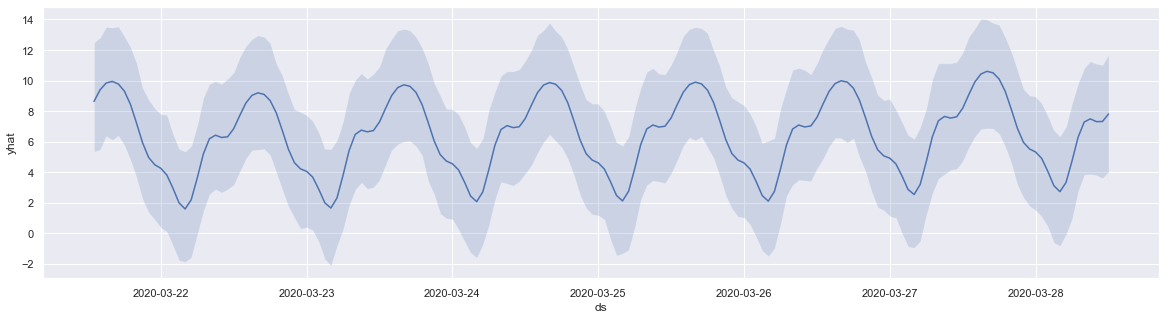

In [60]:
fig, ax = plt.subplots(figsize = (20, 5))
ax = sns.lineplot(x = 'ds', y = 'yhat', data = forecast)
ax.fill_between(forecast['ds'],
               forecast['yhat_lower'],
               forecast['yhat_upper'],
               alpha = 0.2)

### Cross-validation

In [ ]:
cv = cross_validation(model, horizon = '7 days')

INFO:fbprophet:Making 1059 forecasts with cutoffs between 2010-01-23 12:00:00 and 2020-03-14 12:00:00


In [ ]:
mean_absolute_error(cv['yhat'], cv['y'])